In [255]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [357]:
file = open('./.env')
api = file.read()

In [358]:
def search_igdb(n): 
  
    #set up an empty list to append each API call
    output = []
    url = 'https://api-v3.igdb.com/games/?limit=50'
    #establish URL and api_key
    headers = {
    'user-key': api,
    'accept': 'application/json'
     }
    #loops through a list of n length and updates offset after each call
    for i in list(range(n)): 
        offset = 0
        offset += 50*i 
        url_params = {
            'fields':'name, total_rating_count, total_rating, rating_count, rating, popularity, aggregated_rating, aggregated_rating_count, themes, platforms, first_release_date, player_perspectives, hypes, game_modes, game_engines', 
            #'filter[release_dates.platform][any]': '48,49,6',
            'filter[total_rating_count][gte]': '150',
            'filter[rating_count][gte]': '100',
            'filter[aggregated_rating_count][gte]': '10',
            'offset': offset
      
      
      
    #         'filter'= filter[release_dates.platform][any] = 48,49,6
    #         'filter'= filter[total_rating_count][gte] = 1
          }
        #fields=*&filter[release_dates.platform][any]=48,49,6
    
    
        response = requests.get(url, headers=headers, params=url_params)
        #run our request get requests
    
  
    
        list(filter(lambda x: output.append(x), response.json()))
     #and 
  
    return output


In [359]:
video_games = search_igdb(4)
df = pd.DataFrame(video_games)

In [360]:
# sort the games by the highest rating 
df = df.sort_values('total_rating', ascending=False)

In [361]:
# change the index of the DataFrame to the name of the game
df = df.set_index('name')

In [362]:
# drop the column with the game 'IDs'
df = df.drop(['id'], axis=1)

In [363]:
# changing column names
df = df.rename(columns={'aggregated_rating':'critic_review_rating'})
df = df.rename(columns={'aggregated_rating_count':'critic_review_count'})
df = df.rename(columns={'first_release_date':'release_date'})
df = df.rename(columns={'rating':'player_review_rating'})
df = df.rename(columns={'rating_count':'player_review_rating_count'})
df = df.rename(columns={'total_rating':'total_review_rating'})
df = df.rename(columns={'total_rating_count':'total_review_rating_count'})

In [364]:
# replace all na values with an empty string ''
df = df.fillna('')
df

,critic_review_rating,critic_review_count,release_date,game_engines,game_modes,hypes,platforms,player_perspectives,popularity,player_review_rating,player_review_rating_count,themes,total_review_rating,total_review_rating_count
name,,,,,,,,,,,,,,
Red Dead Redemption 2,95.916667,22,1540512000,[26],"[1, 2, 3]",257,"[48, 49]",[2],224.522804,97.457749,205,"[1, 38]",96.687208,227
God of War,96.944444,21,1524182400,,[1],92,[48],[2],117.296647,96.300186,377,"[1, 17]",96.622315,398
The Last of Us Remastered,97.400000,11,1406592000,,"[1, 2]",5,[48],[2],23.352280,93.215751,465,"[1, 19, 21, 23]",95.307876,476
The Legend of Zelda: Breath of the Wild,97.592593,31,1488499200,"[17, 502, 503]",[1],142,"[41, 130]",[2],67.085003,92.582298,469,"[1, 17, 38]",95.087445,500
Super Mario Odyssey,96.705882,19,1509062400,,"[1, 3]",88,[130],[2],37.605908,91.955860,279,"[1, 17, 33, 38]",94.330871,298
Persona 5,93.571429,23,1473897600,,[1],34,"[9, 48]",[2],51.211644,94.825637,163,"[1, 17, 23]",94.198533,186
Mass Effect 2,95.600000,14,1264464000,[351],[1],1,"[6, 9, 12]",[2],26.915687,92.761602,1018,"[1, 18]",94.180801,1032
The Witcher 3: Wild Hunt,91.720000,26,1431993600,[24],[1],179,"[6, 48, 49]",[2],111.789564,96.375350,1370,"[1, 17, 22, 38]",94.047675,1396
Grand Theft Auto V,95.840000,34,1379376000,[26],"[1, 2]",,"[6, 9, 12, 48, 49]","[1, 2]",87.169661,92.055204,1628,"[1, 27, 33, 38]",93.947602,1662


In [365]:
# getting codes for each column 

platforms_codes = list(df['platforms'])
game_engines_codes = list(df['game_engines'])
player_perspectives_codes = list(df['player_perspectives'])
game_modes_codes = list(df['game_modes'])
themes_codes = list(df['themes'])

def unique_column_set(column):
    unique_letters = [] 
    for letters in column:
        for letter in letters:
            if letters != '':
                unique_letters.append(letter)
    return set(unique_letters)

unique_platforms_codes = unique_column_set(platforms_codes)
unique_game_engines_codes = unique_column_set(game_engines_codes)
unique_player_perspectives_codes = unique_column_set(player_perspectives_codes)
unique_game_modes_codes = unique_column_set(game_modes_codes)
unique_themes_codes = unique_column_set(themes_codes)

In [366]:
# getting all the values for release_dates in a unique set

unix_codes = list(df['release_date'])

def unique_release_set(lst):
    unique_dates = [] 
    for date in lst:
                unique_dates.append(date)
    return set(unique_dates)

unique_release_codes = unique_release_set(unix_codes)
len(unique_release_codes)

171

In [367]:
# converting epoch to human readable date
df['release_date'] = pd.to_datetime(df['release_date'], unit='s')

In [368]:
# creating a new column called year which displays just the year the game released in standart date time
df['release_year'] = df['release_date'].dt.year

In [369]:
df.head()

,critic_review_rating,critic_review_count,release_date,game_engines,game_modes,hypes,platforms,player_perspectives,popularity,player_review_rating,player_review_rating_count,themes,total_review_rating,total_review_rating_count,release_year
name,,,,,,,,,,,,,,,
Red Dead Redemption 2,95.916667,22,2018-10-26,[26],"[1, 2, 3]",257,"[48, 49]",[2],224.522804,97.457749,205,"[1, 38]",96.687208,227,2018
God of War,96.944444,21,2018-04-20,,[1],92,[48],[2],117.296647,96.300186,377,"[1, 17]",96.622315,398,2018
The Last of Us Remastered,97.400000,11,2014-07-29,,"[1, 2]",5,[48],[2],23.352280,93.215751,465,"[1, 19, 21, 23]",95.307876,476,2014
The Legend of Zelda: Breath of the Wild,97.592593,31,2017-03-03,"[17, 502, 503]",[1],142,"[41, 130]",[2],67.085003,92.582298,469,"[1, 17, 38]",95.087445,500,2017
Super Mario Odyssey,96.705882,19,2017-10-27,,"[1, 3]",88,[130],[2],37.605908,91.955860,279,"[1, 17, 33, 38]",94.330871,298,2017


# Did video games get better or worse overtime?

In [400]:
# mean values for all columns by release_year
release_year_mean = df.groupby(['release_year']).mean()

Text(0.5, 1.0, 'Average rating of the top game by year')

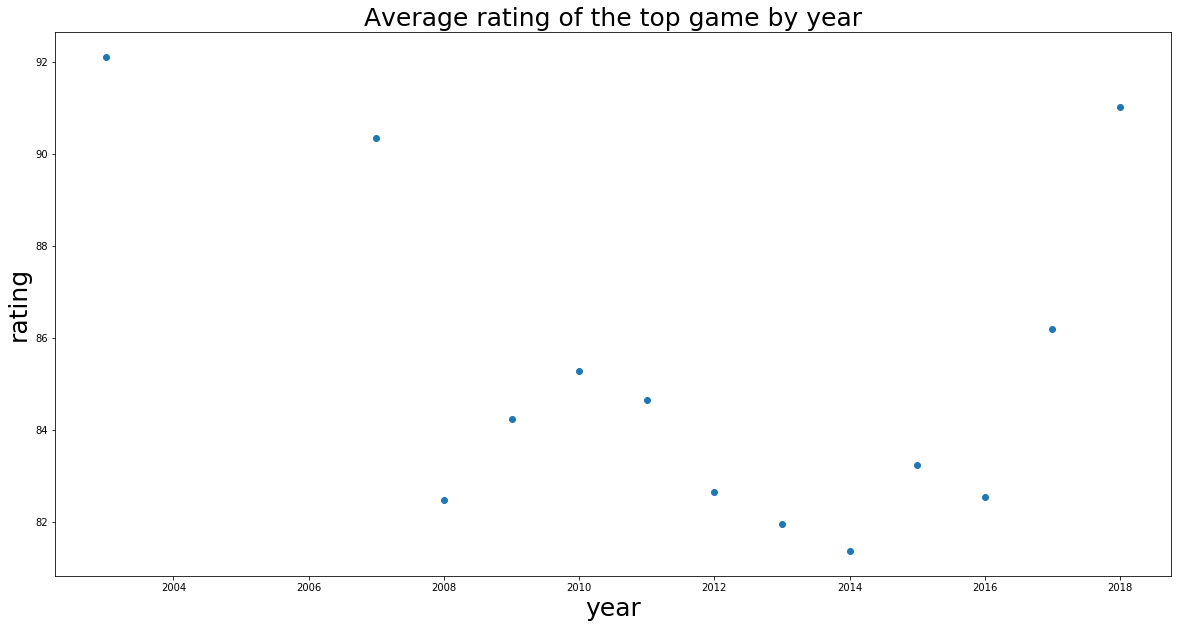

In [402]:
new_figure = plt.figure(figsize=(20,10))
ax = new_figure.add_subplot(111)
ax.scatter(release_year_mean.index , release_year_mean.total_review_rating)
ax.set_xlabel('year', size=25)
ax.set_ylabel('rating', size=25)
ax.set_title('Average rating of the top game by year', size=25)

# Are games considered to be better if they have more game modes?

# Does hypes correlate to games that end up on top?

# Which platforms has the most games in the top 200 list?

In [414]:
# mean values for all columns by release_year

# Do people like to play first person over third person video games?

# Are single player games more popular than multiplayer games?

# Which video game theme is the most popular?